<a href="https://colab.research.google.com/github/ShuichiroTsuda/TrendModel/blob/main/TrendModel(%E5%90%9B%E3%81%AE%E5%90%8D%E3%81%AF).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pytrends

In [3]:
import pandas as pd                        
from pytrends.request import TrendReq
import numpy as np
from scipy.optimize import minimize, basinhopping
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

pytrend = TrendReq(hl='ja-jp')

(array([736177., 736191., 736208., 736222., 736238., 736252., 736269.,
        736283., 736299.]), <a list of 9 Text major ticklabel objects>)

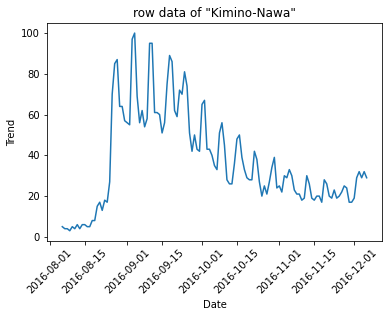

In [4]:
keywords = ['君の名は']
pytrend.build_payload(kw_list=keywords, timeframe='2016-08-06 2016-12-06')
df = pd.DataFrame(pytrend.interest_over_time())
plt.plot(df['君の名は'])
plt.title('row data of "Kimino-Nawa"')
plt.xlabel('Date')
plt.ylabel('Trend')
plt.xticks(rotation=45)

In [5]:
len(df)

123

(array([736191., 736208., 736222., 736238., 736252., 736269., 736283.,
        736299.]), <a list of 8 Text major ticklabel objects>)

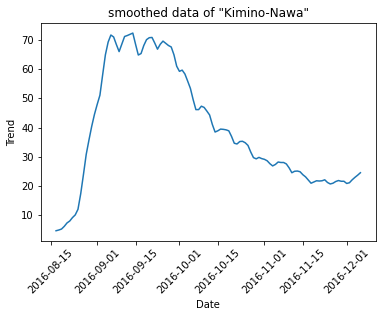

In [6]:
df["rolling"] = df['君の名は'].rolling(12).mean()
df = df.dropna(subset=['rolling'])
plt.plot(df['rolling'])
plt.title('smoothed data of "Kimino-Nawa"')
plt.xlabel('Date')
plt.ylabel('Trend')
plt.xticks(rotation=45)

(array([736191., 736208., 736222., 736238., 736252., 736269., 736283.,
        736299.]), <a list of 8 Text major ticklabel objects>)

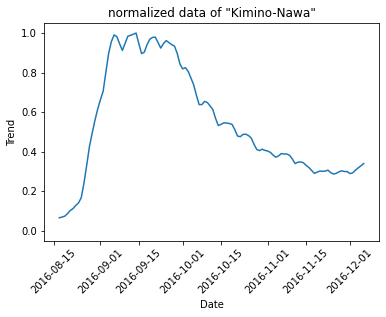

In [26]:
df['normal'] = df['rolling'] / np.max(df['rolling'])
plt.plot(df['normal'])
plt.title('normalized data of "Kimino-Nawa"')
plt.ylim(-0.05, 1.05)
plt.xlabel('Date')
plt.ylabel('Trend')
plt.xticks(rotation=45)

In [8]:
def model1(pars, T, init, DT=1E-1):
    def model1_diff(Y):
        y1, y2, y3, y4 = Y
        return np.array([-pars[0]*y1, pars[0]*y1-(pars[1]+pars[2])*y2, pars[1]*y2, pars[2]*y2])
    # 時点集合
    t_set = np.linspace(0.0, T, int(T/DT) + 1)
    # SIRの各状態を格納する行列
    X = np.zeros((len(t_set),4),dtype='float')
    # 初期値から順に増分を加えることで状態変数を生成
    X[0] = init
    for tid, f in enumerate(t_set[:-1]):
        X[tid+1] = X[tid] + model1_diff(X[tid])*DT
    X = X / np.max(X[:,1]+X[:,3])
    return X, t_set

In [9]:
def model2(pars, T, init, DT=1E-1):
    def model1_diff(Y):
        y1, y2, y3, y4 = Y
        return np.array([-pars[0]*y1*y2, pars[0]*y1*y2-(pars[1]+pars[2])*y2, pars[1]*y2, pars[2]*y2])
    # 時点集合
    t_set = np.linspace(0.0, T, int(T/DT) + 1)
    # SIRの各状態を格納する行列
    X = np.zeros((len(t_set),4),dtype='float')
    # 初期値から順に増分を加えることで状態変数を生成
    X[0] = init
    for tid, f in enumerate(t_set[:-1]):
        X[tid+1] = X[tid] + model1_diff(X[tid])*DT
    X = X / np.max(X[:,1]+X[:,3])
    return X, t_set

In [10]:
def rmse1(pars,obs):
    init = (0.97, 0.01, 0.01, 0.01)
    Y, t_set = model1(pars, len(obs), init)
    Y = Y[t_set >= 1]
    t_set = t_set[t_set>=1]
    y1 = Y[t_set%1==0, 0]
    y2 = Y[t_set%1==0, 1]
    y3 = Y[t_set%1==0, 2]
    y4 = Y[t_set%1==0, 3]
    ret = np.sqrt(np.average((obs - y2 - y4)**2))
    return ret

In [11]:
def rmse2(pars,obs):
    init = (0.97, 0.01, 0.01, 0.01)
    Y, t_set = model2(pars, len(obs), init)
    Y = Y[t_set >= 1]
    t_set = t_set[t_set>=1]
    y1 = Y[t_set%1==0, 0]
    y2 = Y[t_set%1==0, 1]
    y3 = Y[t_set%1==0, 2]
    y4 = Y[t_set%1==0, 3]
    ret = np.sqrt(np.average((obs - y2 - y4)**2))
    return ret

In [12]:
data = df['normal']

In [13]:
opt1 = basinhopping(rmse1, [0.05, 0.04, 0.002], minimizer_kwargs={"args": data, "method": "L-BFGS-B"})
print(opt1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in double_scalars
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in add
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in add
  del sys.path[0]


                        fun: 0.1455715665465886
 lowest_optimization_result:       fun: 0.1455715665465886
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.39055434e-06, -2.98094882e-06,  8.66251515e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 504
      nit: 46
   status: 0
  success: True
        x: array([ 0.03846133,  0.03055058, -0.00134703])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 0
                       nfev: 2592
                        nit: 100
                          x: array([ 0.03846133,  0.03055058, -0.00134703])


Text(0, 0.5, 'Trend')

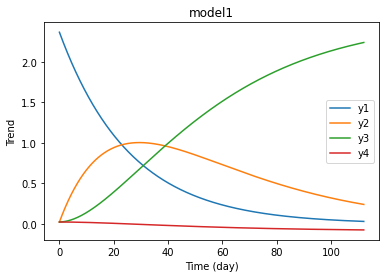

In [14]:
T = len(data)
init = (0.97, 0.01, 0.01, 0.01)
X1, t_set = model1(opt1.x, T, init)
fig, ax = plt.subplots()
labels = ["y1", "y2", "y3", "y4"]
for i in range(4):
    ax.plot(t_set, X1[:,i], label=labels[i])
ax.legend()
plt.title('model1')
plt.xlabel('Time (day)')
plt.ylabel('Trend')

Text(0, 0.5, 'Trend')

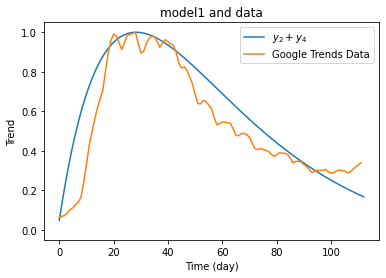

In [27]:
plt.plot(t_set ,X1[:,1]+X1[:,3], label='$y_2+y_4$')
plt.plot(pd.RangeIndex(start=0, stop=len(data.index), step=1),data, label='Google Trends Data')
plt.legend()
plt.ylim(-0.05, 1.05)
plt.title('model1 and data')
plt.xlabel('Time (day)')
plt.ylabel('Trend')

In [16]:
opt2 = basinhopping(rmse2, [0.51843, 0.02855063, 0.00793422], minimizer_kwargs={"args": data, "method": "L-BFGS-B"})
print(opt2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in double_scalars
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/scipy/optimize/optimize.py:697: RuntimeWarning: invalid value encountered in double_scalars
  df = (f(*((xk + d,) + args)) - f0) / d[k]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in add
  del sys.path[0]


                        fun: 0.05102610582579759
 lowest_optimization_result:       fun: 0.05102610582579759
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 4.85722573e-09, -1.31521877e-04,  9.82242065e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 160
      nit: 22
   status: 0
  success: True
        x: array([ 3.27425796e-01,  1.72412130e-02, -1.97942217e-04])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 5
                       nfev: 2392
                        nit: 100
                          x: array([ 3.27425796e-01,  1.72412130e-02, -1.97942217e-04])


Text(0, 0.5, 'Trend')

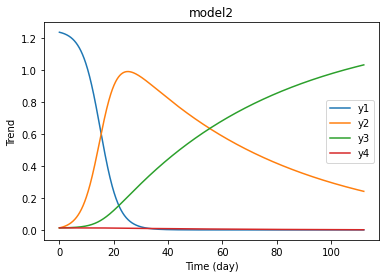

In [17]:
T = len(data)
init = (0.97, 0.01, 0.01, 0.01)
X2, t_set = model2(opt2.x, T, init)
fig, ax = plt.subplots()
labels = ["y1", "y2", "y3", "y4"]
for i in range(4):
    ax.plot(t_set, X2[:,i], label=labels[i])
ax.legend()
plt.title('model2')
plt.xlabel('Time (day)')
plt.ylabel('Trend')

Text(0, 0.5, 'Trend')

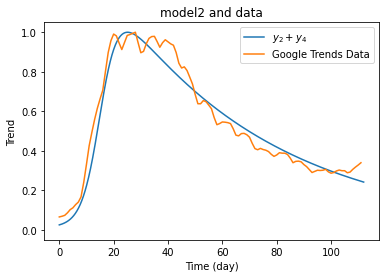

In [28]:
plt.plot(t_set ,X2[:,1]+X2[:,3],label='$y_2+y_4$')
plt.plot(pd.RangeIndex(start=0, stop=len(data.index), step=1),data, label='Google Trends Data')
plt.legend()
plt.ylim(-0.05, 1.05)
plt.title('model2 and data')
plt.xlabel('Time (day)')
plt.ylabel('Trend')

1121
112
